# Code to perform MCMC inference on simulated data, including frequency correlations

### - Import libraries

In [1]:
# Global imports
import sys
import tqdm
import numpy as np
import emcee
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

sys.path.append("../")

# Local imports
import examples_utils as eu
from fastPTA import get_tensors as gt
from fastPTA import utils as ut
from fastPTA.data import generate_data as gd
from fastPTA import plotting_functions as pf
from fastPTA.angular_decomposition import spherical_harmonics as sph
from fastPTA.data import data_correlations as dc
from fastPTA.inference_tools import likelihoods as lk

print(eu.path_to_file)
%reload_ext autoreload
%autoreload 2
jax.config.update("jax_enable_x64", True)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern"],
        "axes.labelsize": 14,
        "font.size": 12,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
    }
)

/home/pieroni/my_projects/fastPTA_papers/paper_cosmic_variance/fastpta_anisotropies/examples/examples_paper_cosmic_variance/..


### - Some general constants

In [2]:
# Total observation time in years
Tspan_yrs = 16.0

# Total observation span in seconds
Tspan = Tspan_yrs * ut.yr

# Number of pulsars in the array
npulsars = 100

### - Define the frequency part

In [3]:
# Number of frequency bins to consider
nfreqs = 10

# Step size for frequency sampling (dimensionless, to be divided by Tspan)
df_step = 0.1

# Starting frequency index (dimensionless, to be divided by Tspan)
f_in = 0.5

# Frequency array sampled with step size df_step, divided by total observation time
ff = jnp.arange(f_in, nfreqs + 1, step=df_step) / Tspan

# Frequency array sampled at integer multiples of 1/Tspan
fi = jnp.arange(1, nfreqs + 1) / Tspan

# Power spectral density evaluated at frequencies ff, following a power law f^(-7/3)
S_ff = (ff / ut.f_yr) ** -7.0 / 3.0

# Power spectral density evaluated at frequencies fi, following a power law f^(-7/3)
S_fi = (fi / ut.f_yr) ** -7.0 / 3.0

### - Define the angular structure

In [4]:
# Maximum multipole order for spherical harmonics decomposition
l_max = 3

# HEALPix resolution parameter (number of divisions on the sphere)
Nside = 8

# Initialize spherical harmonic coefficients (real form, up to l_max)
clms_real = np.zeros(sph.get_n_coefficients_real(l_max))

# Set monopole component (l = 0, m = 0) to 1.0
clms_real[0] = 1.0

# Set dipole component (l = 1, m = 0) to maximal value
clms_real[2] = 1.0 / np.sqrt(3)

# Normalize coefficients
clms_real /= np.sqrt(4 * np.pi)

### - Define the angular power spectrum

In [5]:
# Convert spherical harmonic coefficients (real) into a sky map (Pk)
Pk = sph.get_map_from_real_clms(clms_real, Nside, l_max=l_max)

# Construct frequency-dependent power distribution across the sky
H_p_ff = Pk[:, None] * S_ff[None, :]

### - define wrapper for the MCMC injection - recovery

In [6]:
def run_mcmc(
    data,
    Nside,
    l_max,
    gamma_IJ_lm,
    C_ff,
    initial_guess,
    ndim,
    nwalkers,
    nsteps,
    initial_spread=1e-2,
):

    p0 = initial_guess + initial_spread * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        lk.log_posterior_full,
        args=(Nside, l_max, data, gamma_IJ_lm, C_ff),
    )

    sampler.run_mcmc(p0, nsteps, progress=True)

    return sampler


def runner(npulsars, clms_real, MCMC_steps, MCMC_burnin):
    # Compute frequency-domain normalization matrix for pulsar correlations
    C_ff = dc.get_D_IJ_fifj_normalization(Tspan, fi, ff, H_p_ff)

    # Generate pulsars, data streams and get the data correlations
    p_vec, _, D_IJ_ij = gd.generate_D_IJ_fifj(
        Nside, npulsars, Tspan, fi, ff, H_p_ff
    )

    # Compute spherical harmonic correlations γ_IJ^lm for pulsar pairs
    gamma_IJ_lm = gt.get_correlations_lm_IJ(p_vec, l_max, Nside)

    # Set up MCMC initial point
    initial_guess = clms_real
    ndim = len(initial_guess)

    # define MCMC parameters
    nwalkers = 2 * ndim
    nsteps = MCMC_steps

    # Run MCMC sampler
    sampler = run_mcmc(
        D_IJ_ij,
        Nside,
        l_max,
        gamma_IJ_lm,
        C_ff,
        initial_guess,
        ndim,
        nwalkers,
        nsteps,
        initial_spread=1e-2,
    )

    # Flatten the chains after burn-in phase
    flat_samples = sampler.get_chain(discard=MCMC_burnin, flat=True)

    # Compute posterior mean of parameters
    posterior_mean = np.mean(flat_samples, axis=0)

    # Compute posterior standard deviation of parameters
    posterior_std = np.std(flat_samples, axis=0)

    # Plot MCMC results: chains, posterior distributions, and comparisons
    pf.plot_chain_results(
        flat_samples, posterior_mean, posterior_std, clms_real
    )

    # Return posterior statistics and full sample chain
    return posterior_mean, posterior_std, flat_samples

### - Example injection + MCMC inference

  0%|          | 0/100 [00:00<?, ?it/s]/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


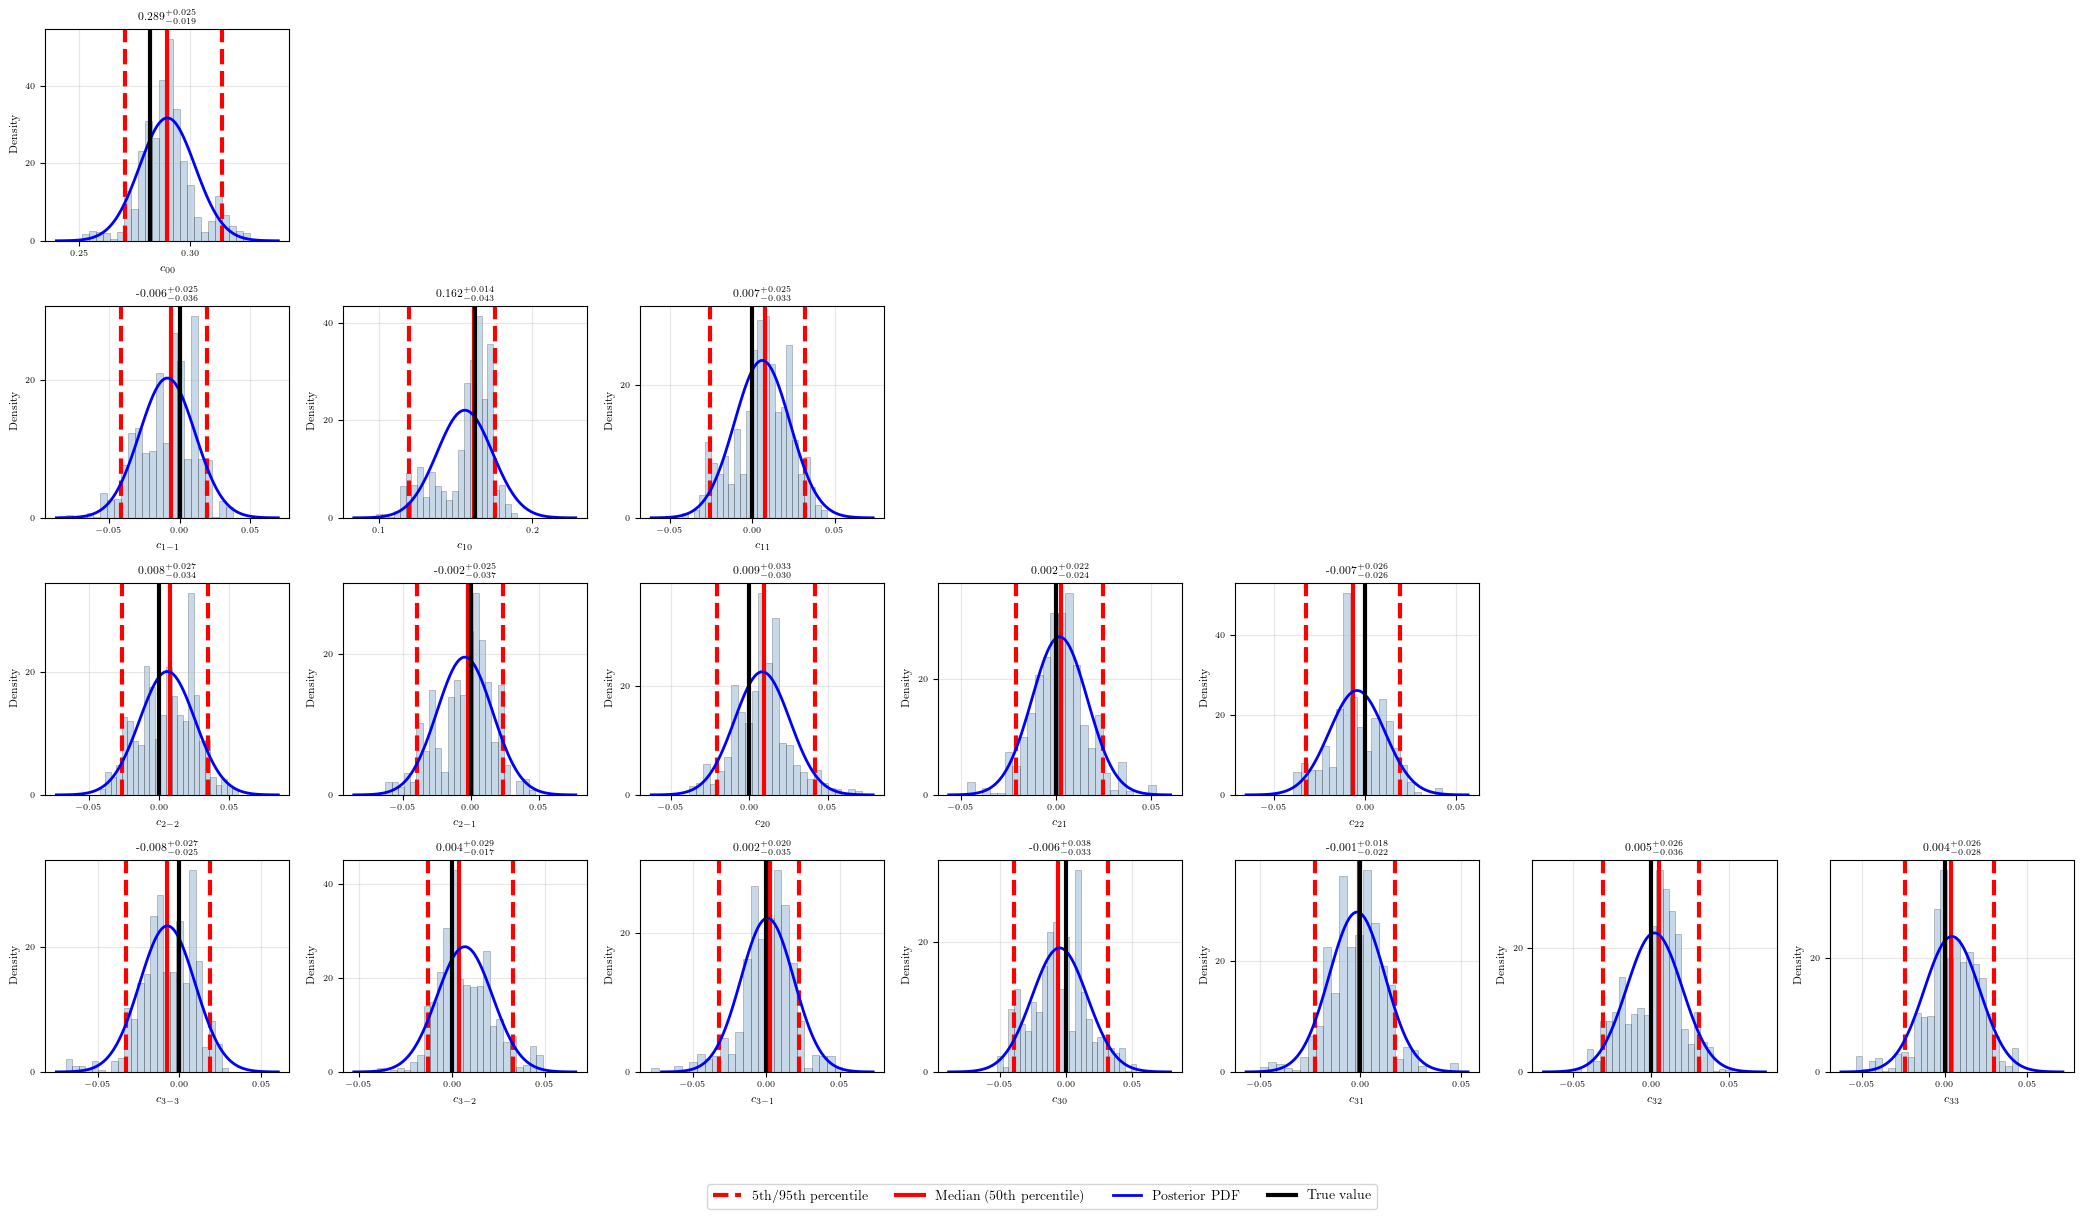

In [7]:
# Scaling factor to adjust MCMC parameters (use >1 for longer, more precise runs)
scale = 1

# Number of MCMC steps per walker
MCMC_steps = scale * 100

# Number of initial burn-in steps to discard
MCMC_burnin = scale * 20

# Run a single MCMC inference with the given pulsar array and coefficients
# Returns: posterior mean, posterior std, and full flattened MCMC samples
posterior_mean, posterior_std, flat_samples = runner(
    npulsars, clms_real, MCMC_steps, MCMC_burnin
)

### - Wrapper to perform multiple injection - recovery

In [8]:
def run_multiple_realizations(
    n_realizations, npulsars, clms_real, MCMC_steps, MCMC_burnin
):
    # Store posterior means from each realization
    all_means = []

    # Store posterior standard deviations from each realization
    all_stds = []

    # Loop over the number of realizations, with progress bar
    for i in tqdm.tqdm(range(n_realizations)):

        # Run one MCMC realization (pulsar array + sampling)
        posterior_mean, posterior_std, flat_samples = runner(
            npulsars, clms_real, MCMC_steps, MCMC_burnin
        )

        # Save mean of posterior distribution for this run
        all_means.append(posterior_mean)

        # Save std of posterior distribution for this run
        all_stds.append(posterior_std)

    # Convert collected results into arrays for easier analysis
    return np.array(all_means), np.array(all_stds)

  0%|          | 0/5 [00:00<?, ?it/s]

/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


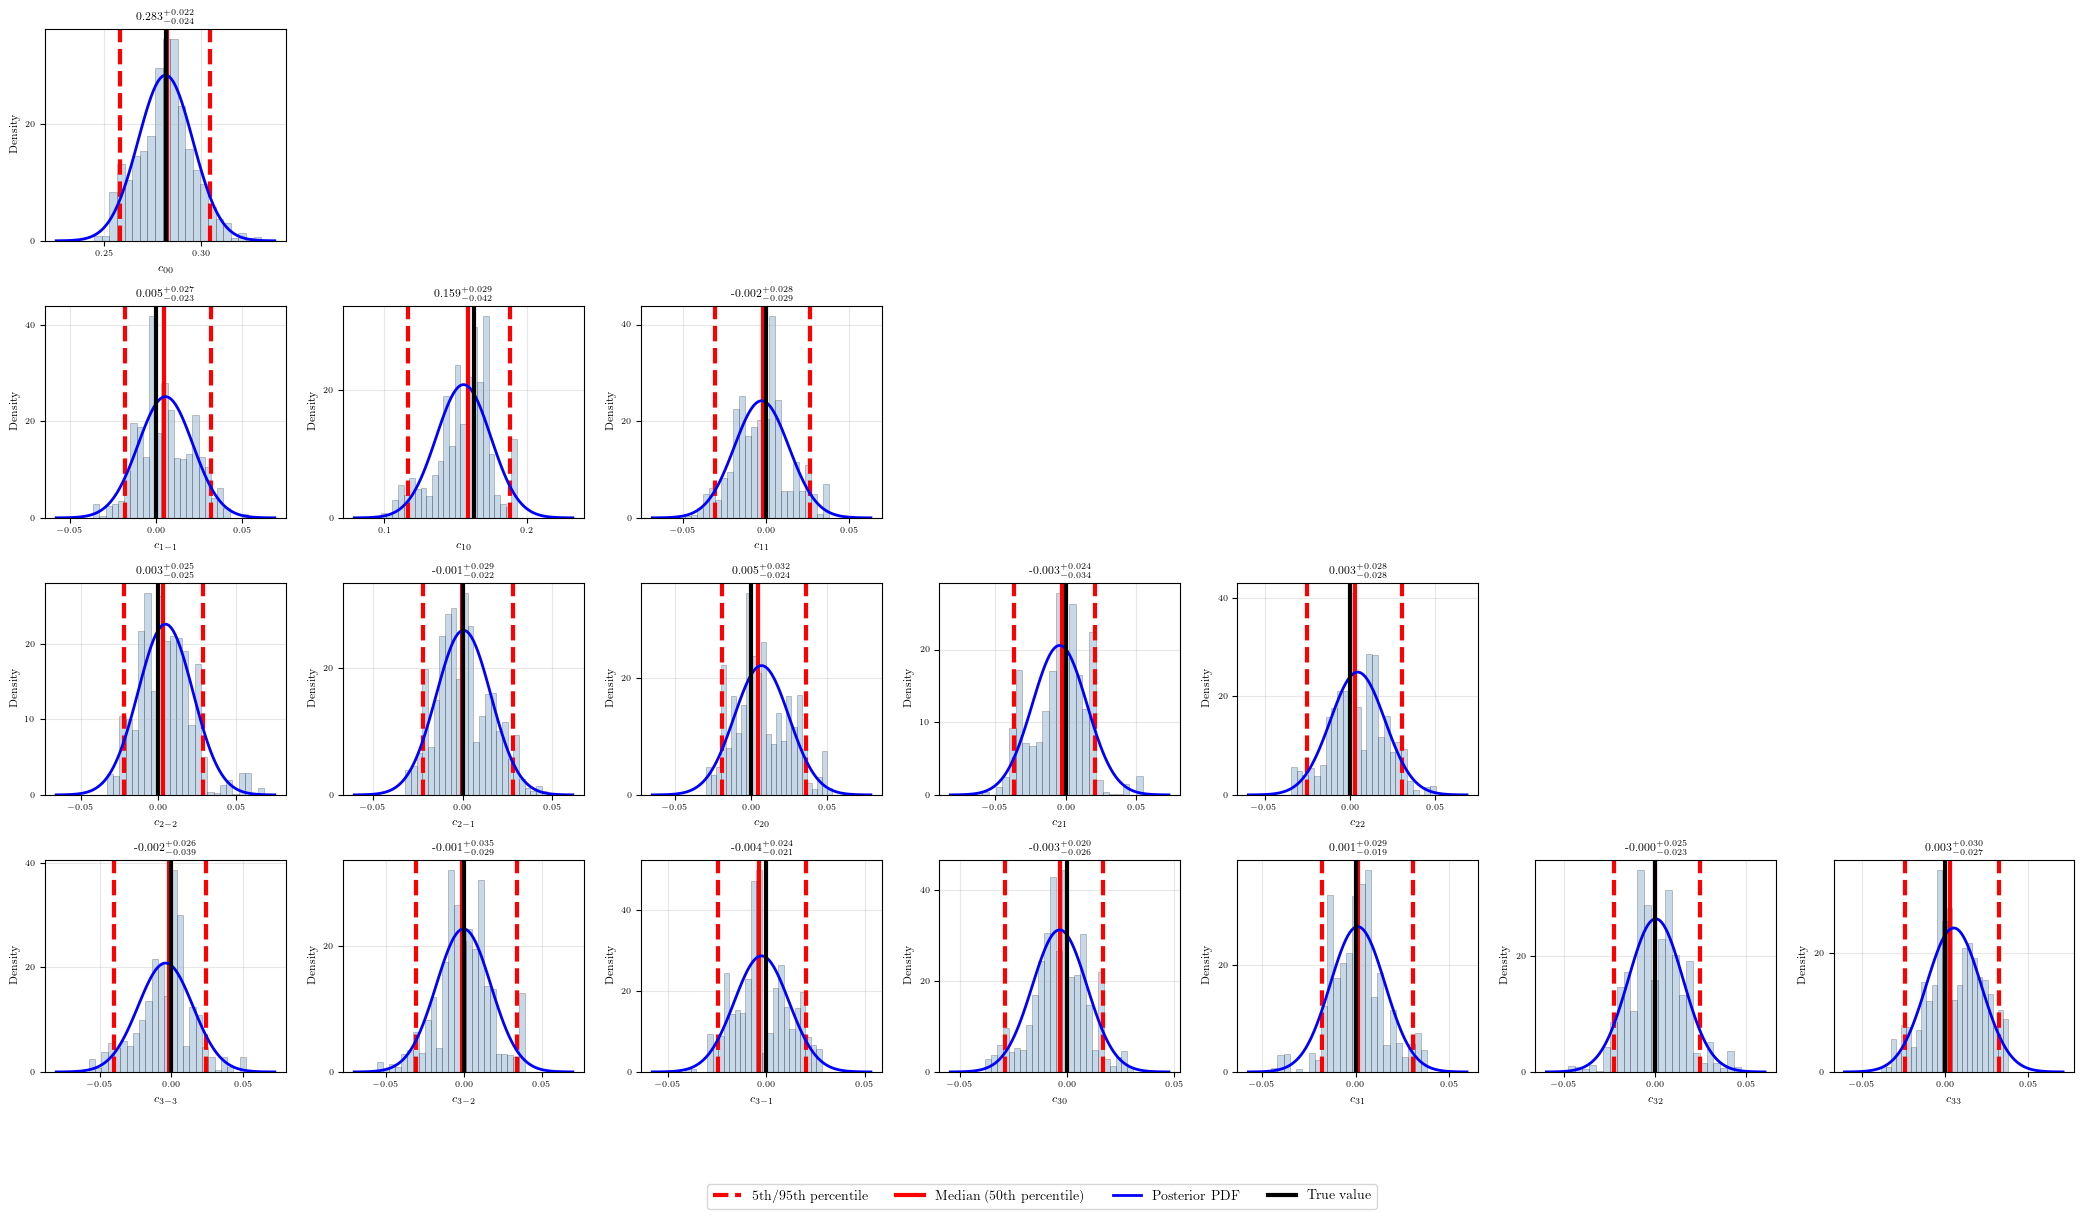

 20%|██        | 1/5 [02:11<08:46, 131.58s/it]/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


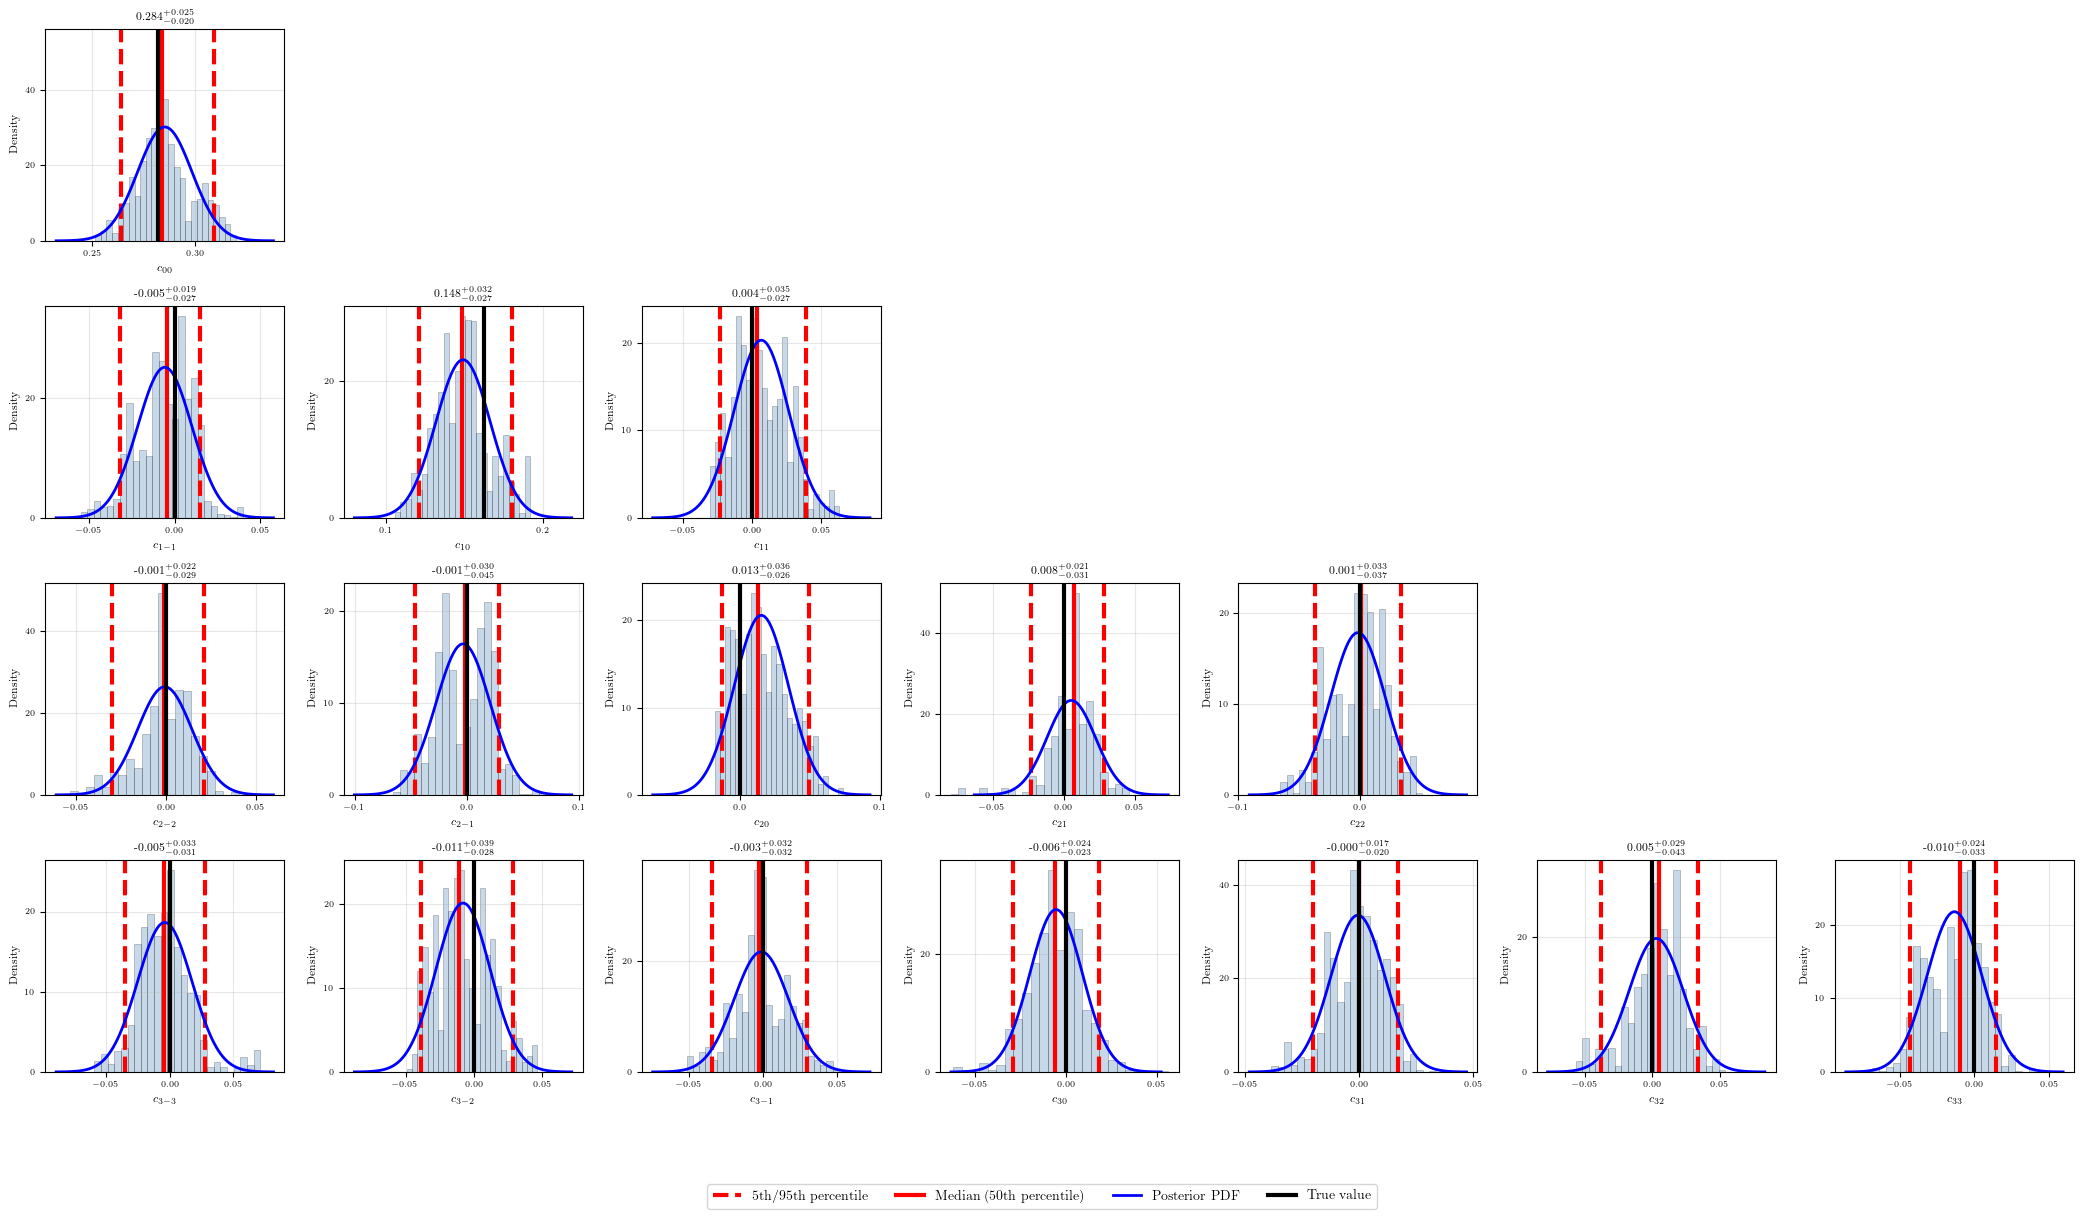

 40%|████      | 2/5 [04:21<06:31, 130.62s/it]/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


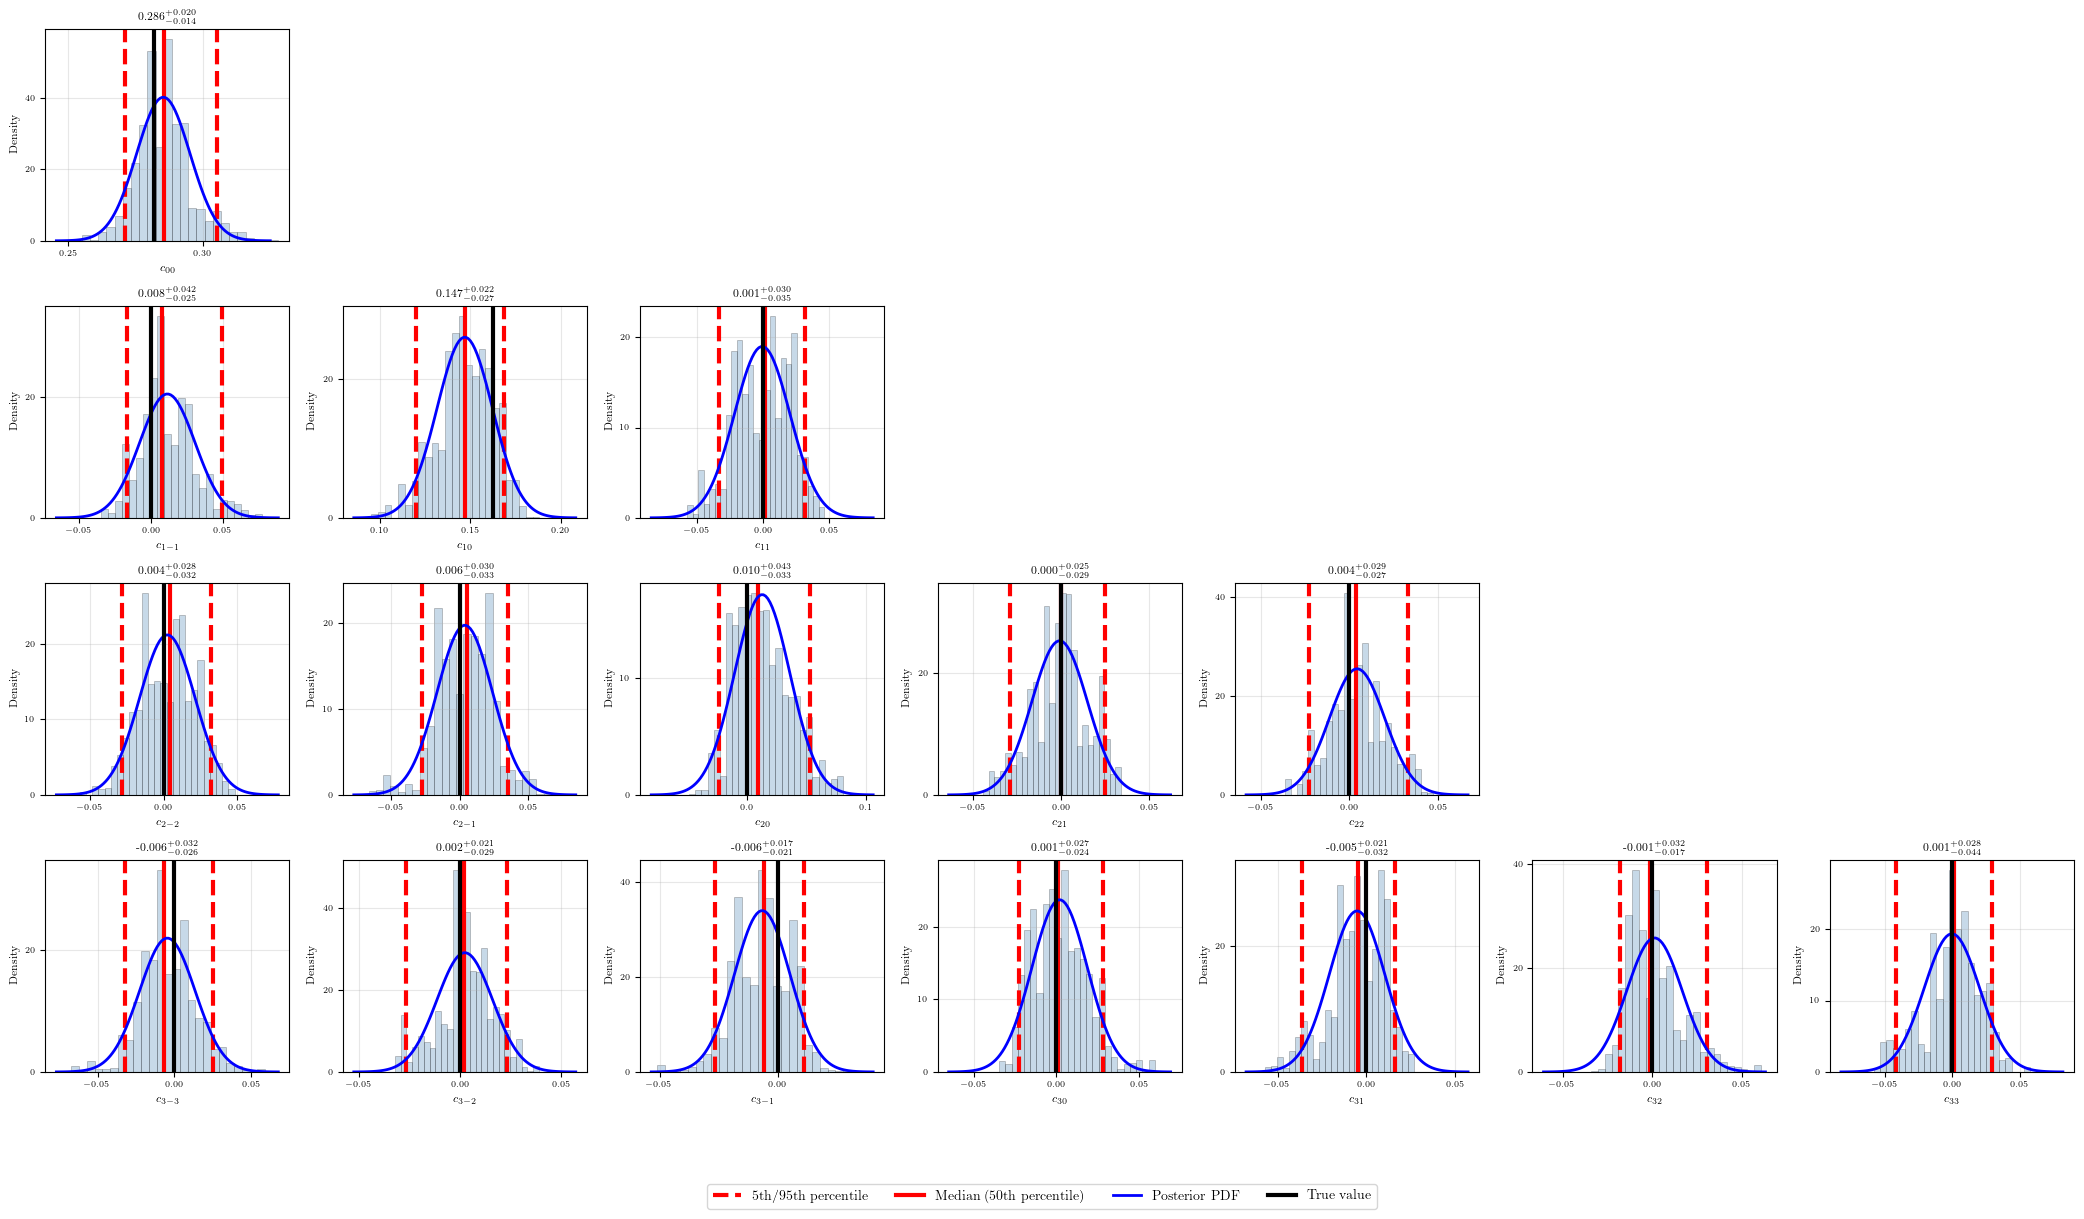

 60%|██████    | 3/5 [06:32<04:21, 130.63s/it]/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


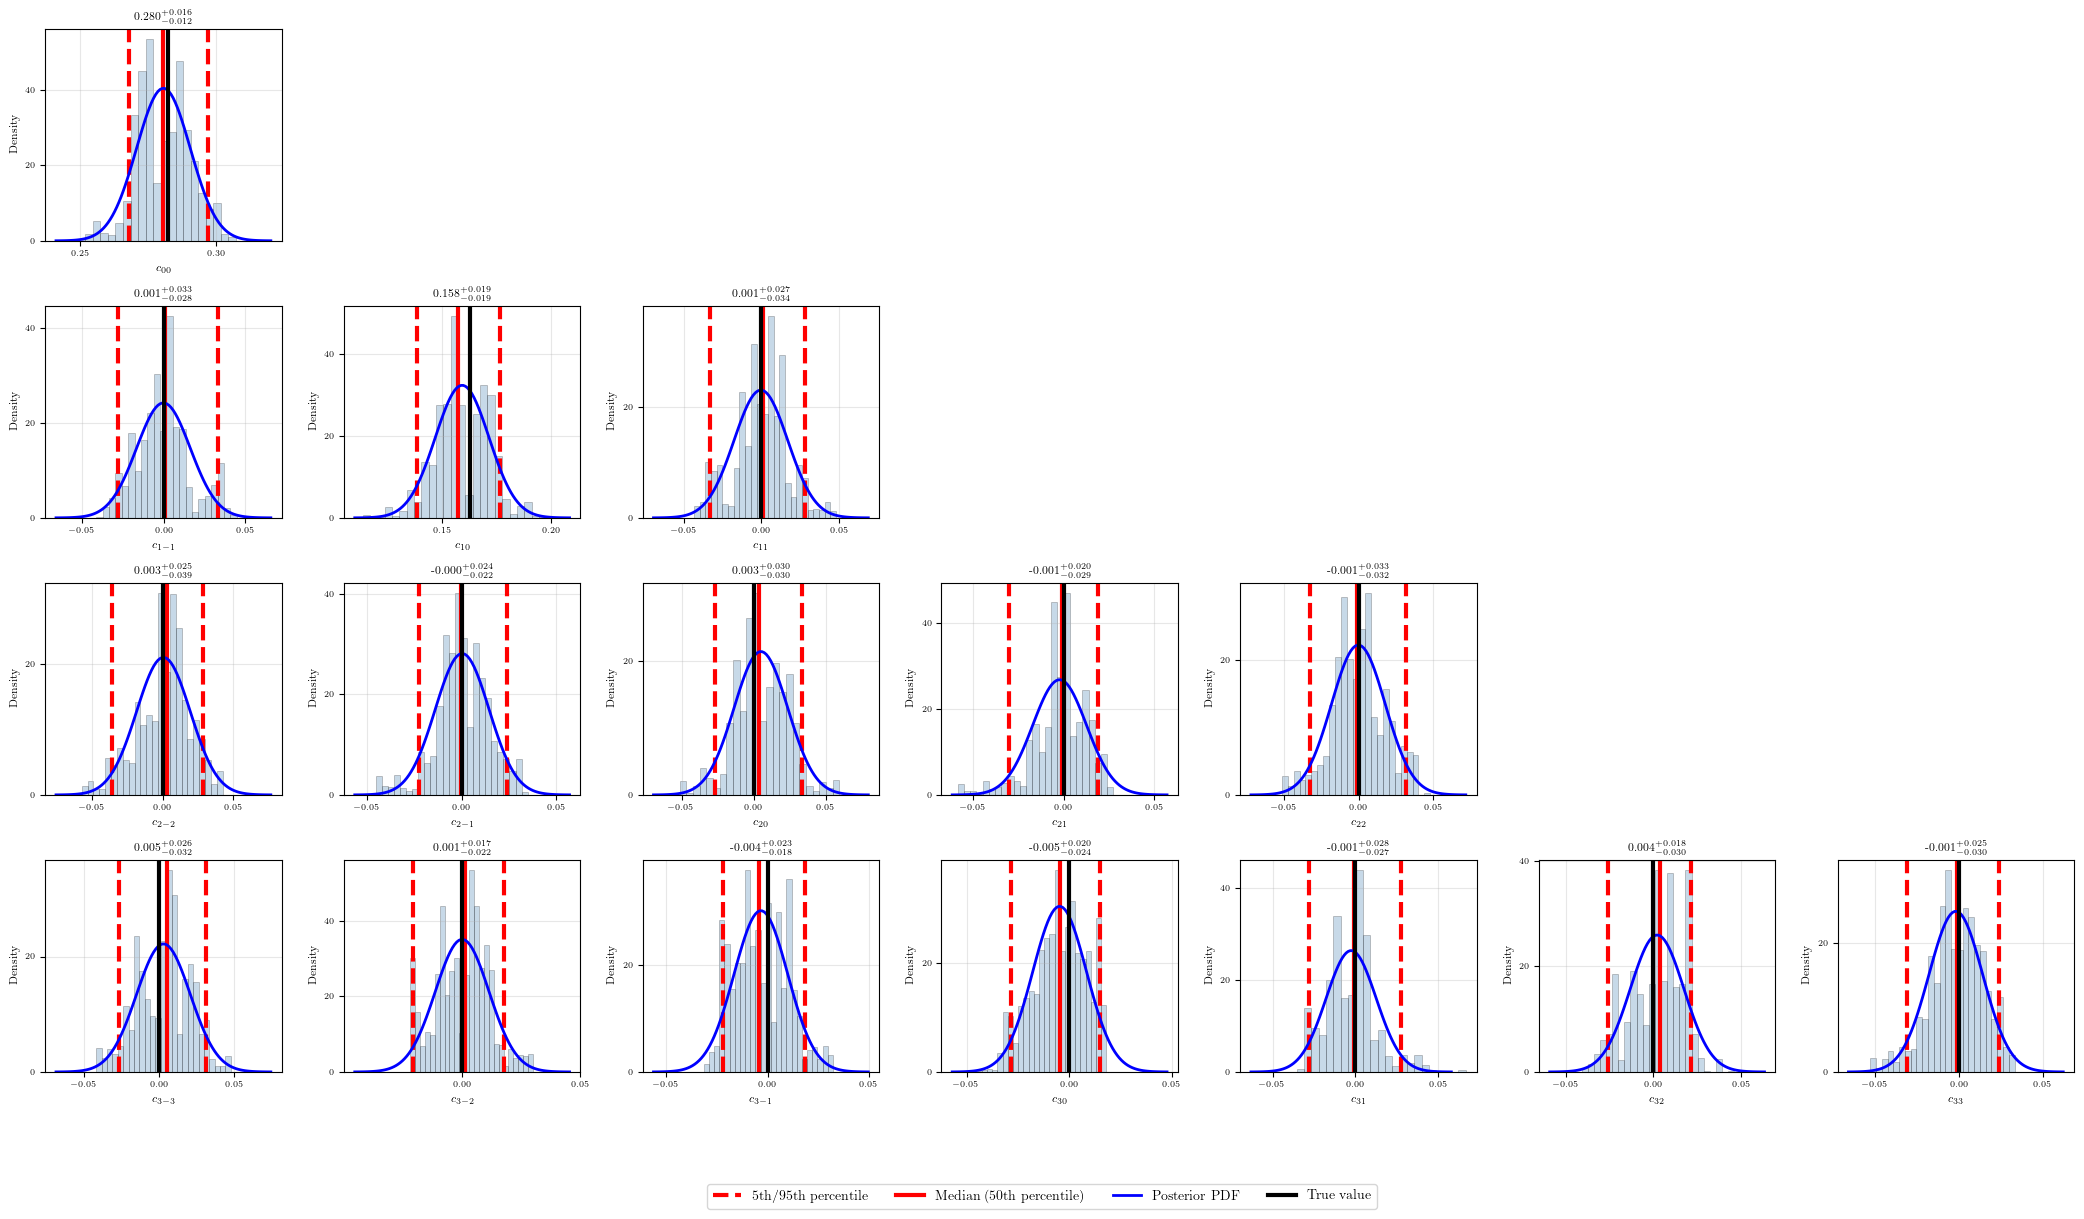

 80%|████████  | 4/5 [08:42<02:10, 130.38s/it]/home/mauro/.pyenv/versions/3.10.8/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


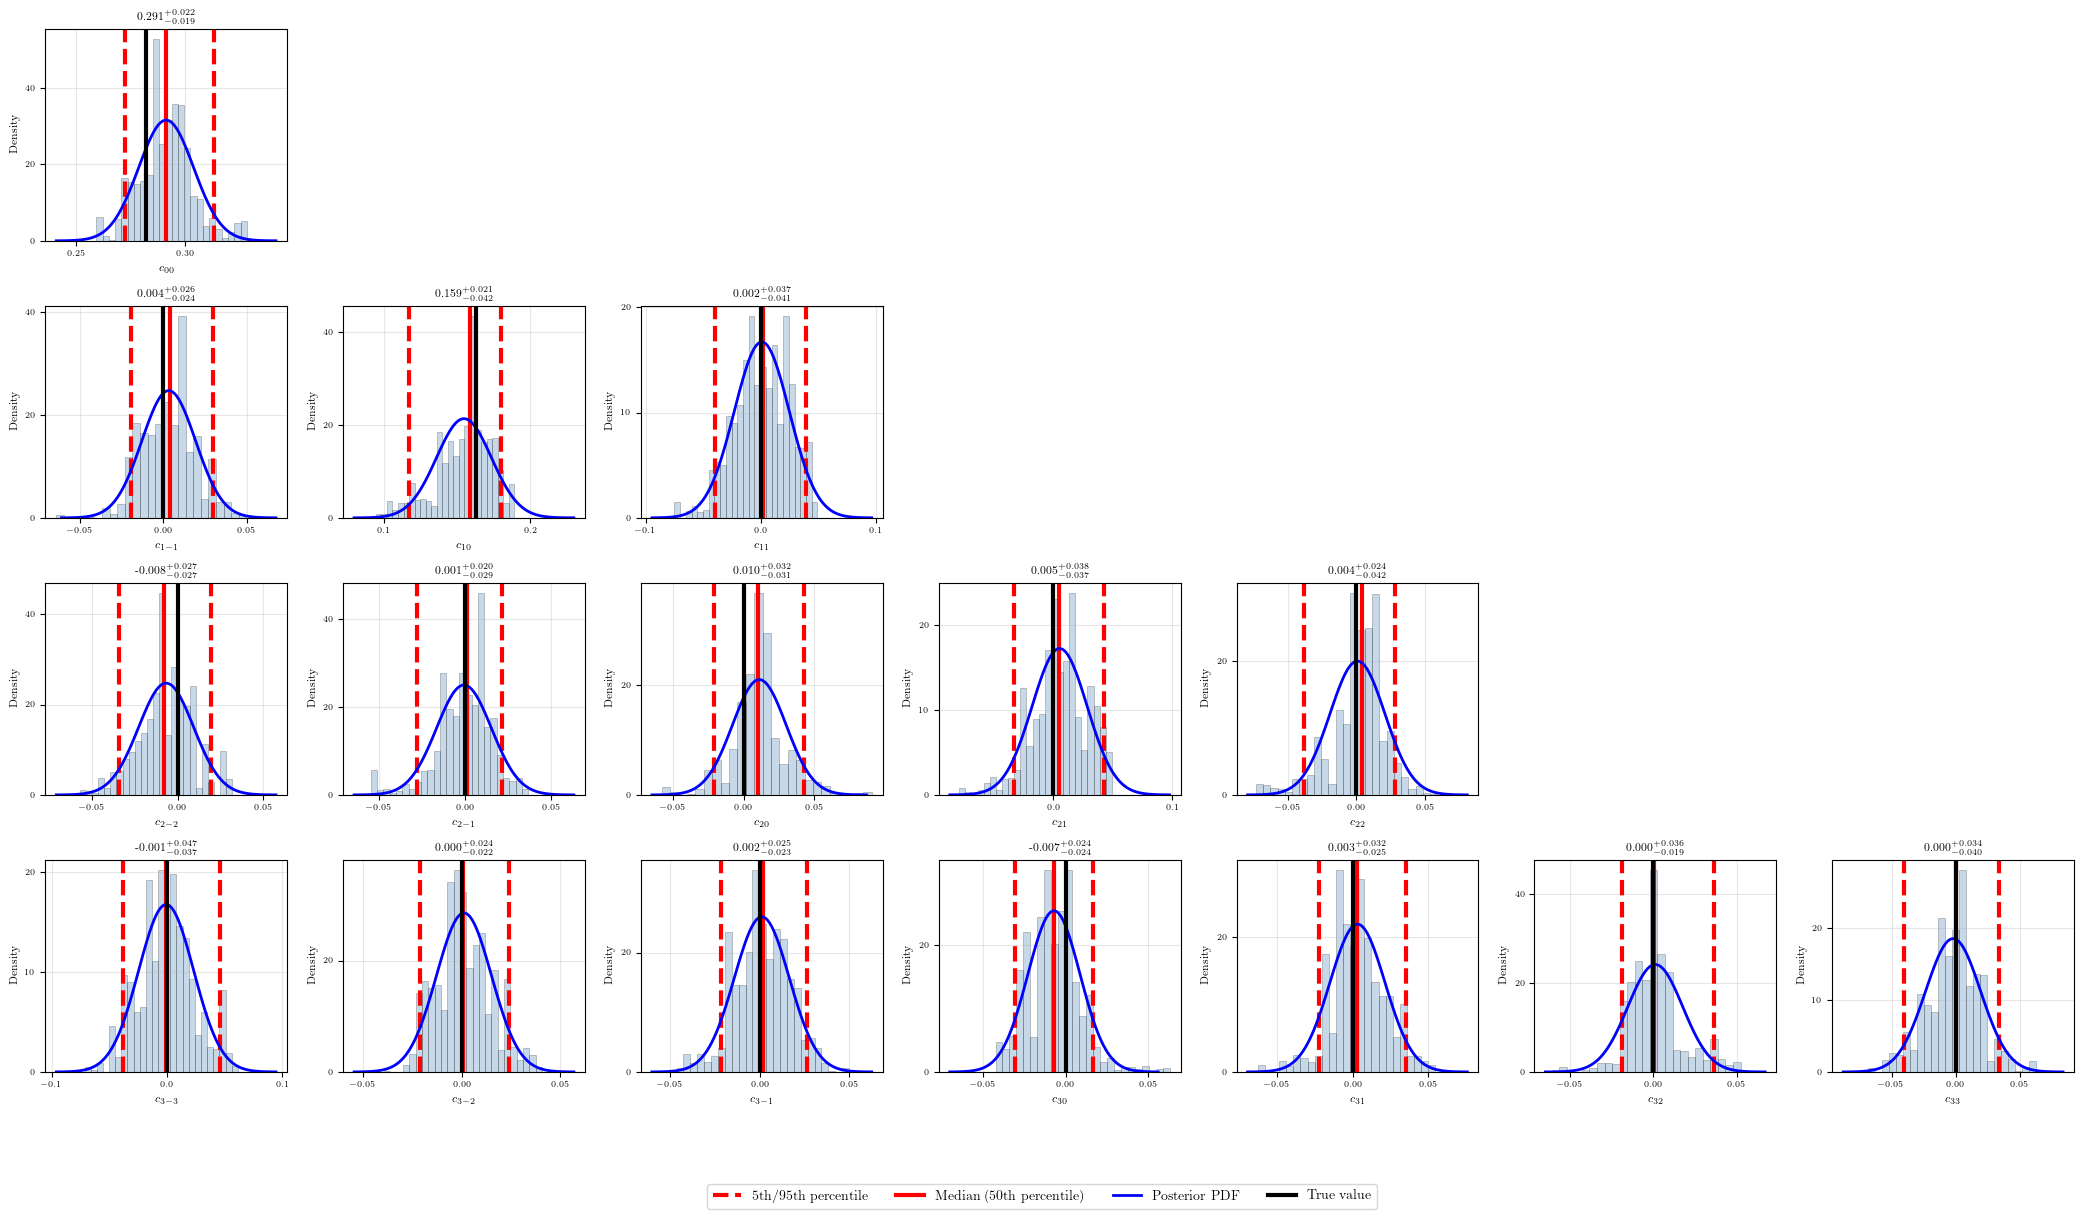

100%|██████████| 5/5 [10:54<00:00, 130.83s/it]


In [9]:
# Number of independent realizations of the simulation/MCMC to run
n_realizations = 5

# Initialize spherical harmonic coefficients (real form, up to l_max)
clms_real = np.zeros(sph.get_n_coefficients_real(l_max))

# Set monopole component (l=0, m=0) to 1.0
clms_real[0] = 1.0

# Set dipole component (l=1, m=0) to normalized value
clms_real[2] = 1.0 / np.sqrt(3)

# Normalize coefficients
clms_real /= np.sqrt(4 * np.pi)

# Scaling factor for MCMC settings (can be tuned for faster tests vs. longer runs)
scale = 1

# Number of MCMC steps per walker
MCMC_steps = scale * 100

# Number of burn-in steps to discard
MCMC_burnin = scale * 20

# Run multiple realizations of the MCMC inference,
# collecting posterior means and standard deviations across runs
all_means, all_stds = run_multiple_realizations(
    n_realizations, npulsars, clms_real, MCMC_steps, MCMC_burnin
)

In [10]:
# Compute the mean of posterior means across all realizations (axis=0 = average over runs)
# Then normalize each coefficient by dividing by the input "true" value (clms_real)
# → This shows how well the recovered coefficients match the injected ones (ratio ≈ 1 means accurate recovery).
print(np.mean(all_means, axis=0) / clms_real)

[1.00982923        inf 0.94064417        inf        inf        inf
        inf        inf        inf       -inf       -inf       -inf
       -inf       -inf        inf       -inf]


/tmp/ipykernel_142420/3757848923.py:4: RuntimeWarning: divide by zero encountered in divide
  print(np.mean(all_means, axis=0) / clms_real)
